# Understanding MLE and Loss Functions
## Through Residual Distributions

**Key Questions:**
1. What are the THREE distributions in machine learning?
2. Why does MSE optimize for the mean?
3. Why does MAE optimize for the median?
4. What is regularization from a Bayesian perspective?
5. Why does class imbalance break our models?

---
## Setup

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

# Set plot style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
%matplotlib inline

---
# Part 1: Regression
---

## 1.1 The Three Distributions

**Common misconception:** "My data isn't normally distributed, so I shouldn't use MSE."

**Reality:** There are **THREE** different distributions in ML:

| Distribution | Description | Loss function assumes about |
|-------------|-------------|-----------------------------|
| $P(X)$ | Input distribution | Nothing! |
| $f: X \to y$ | Learned function | Not a distribution! |
| $P(y - f(X))$ | **Residual distribution** | **THIS is what matters!** |

### Let's generate some data

In [2]:
# Generate regression data
n_samples = 500
X = np.random.randn(n_samples, 1) * 2
true_slope, true_intercept = 3.0, 1.0
noise = np.random.randn(n_samples) * 2  # Gaussian noise!
y = true_slope * X.flatten() + true_intercept + noise

print(f"Generated {n_samples} samples")
print(f"True relationship: y = {true_slope}x + {true_intercept} + noise")

Generated 500 samples
True relationship: y = 3.0x + 1.0 + noise


### Distribution 1: The input distribution $P(X)$

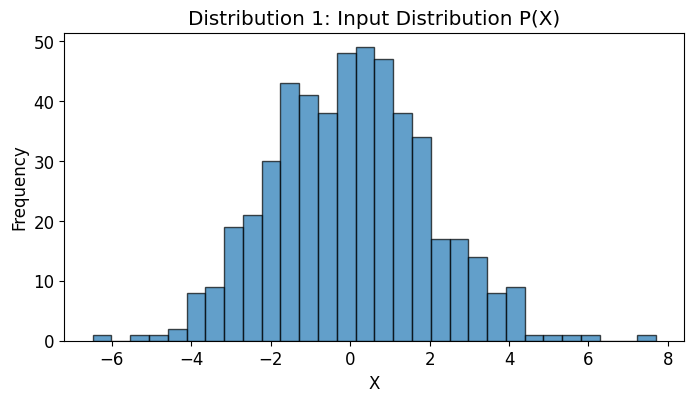

In [3]:
plt.figure(figsize=(8, 4))
plt.hist(X, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('X')
plt.ylabel('Frequency')
plt.title('Distribution 1: Input Distribution P(X)')
plt.show()

### Distribution 2: The learned function $f: X \to y$

**This is NOT a distribution — it's a mapping!**

In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

print(f"Learned: y = {model.coef_[0]:.2f}x + {model.intercept_:.2f}")
print(f"True:    y = {true_slope}x + {true_intercept}")

Learned: y = 2.92x + 1.06
True:    y = 3.0x + 1.0


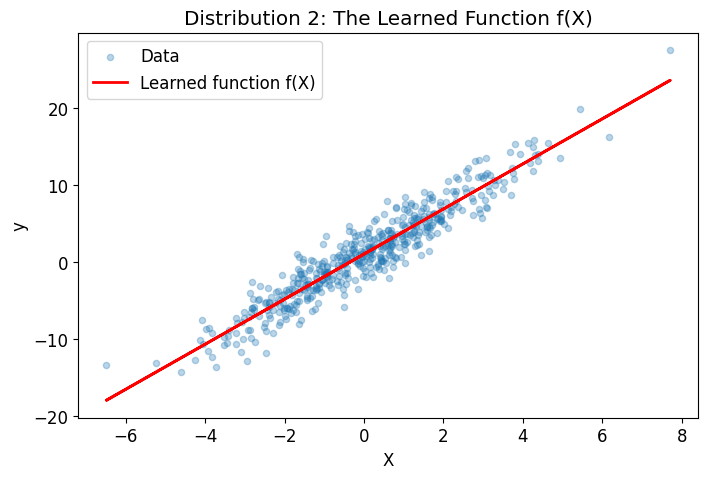

In [5]:
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.3, s=20, label='Data')
plt.plot(X, y_pred, 'r-', linewidth=2, label='Learned function f(X)')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Distribution 2: The Learned Function f(X)')
plt.legend()
plt.show()

### Distribution 3: The residual distribution $P(y - f(X))$

**THIS is what the loss function assumes!**

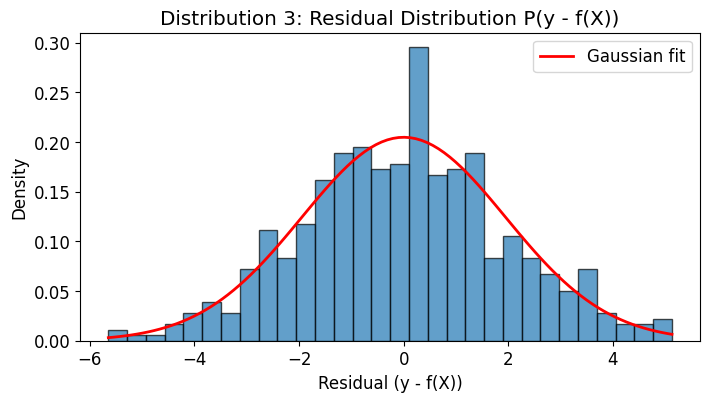

Residual mean: 0.0000 (should be ~0)
Residual std:  1.9484


In [6]:
residuals = y - y_pred

plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, density=True, edgecolor='black', alpha=0.7)

# Overlay Gaussian fit
x_range = np.linspace(residuals.min(), residuals.max(), 100)
gaussian_fit = stats.norm.pdf(x_range, residuals.mean(), residuals.std())
plt.plot(x_range, gaussian_fit, 'r-', linewidth=2, label='Gaussian fit')

plt.xlabel('Residual (y - f(X))')
plt.ylabel('Density')
plt.title('Distribution 3: Residual Distribution P(y - f(X))')
plt.legend()
plt.show()

print(f"Residual mean: {residuals.mean():.4f} (should be ~0)")
print(f"Residual std:  {residuals.std():.4f}")

### Key Insight

> **MSE assumes RESIDUALS are Gaussian, not inputs!**
>
> Your input data can have any distribution — what matters is the distribution of $y - f(X)$.

---
## 1.2 From Gaussian MLE to MSE

**Why does minimizing MSE correspond to Gaussian residuals?**

### Step 1: The Gaussian Distribution

Assume residuals follow a Gaussian distribution:

$$\epsilon_i = y_i - f(x_i) \sim \mathcal{N}(0, \sigma^2)$$

The probability density function:

$$p(\epsilon_i) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{\epsilon_i^2}{2\sigma^2}\right)$$

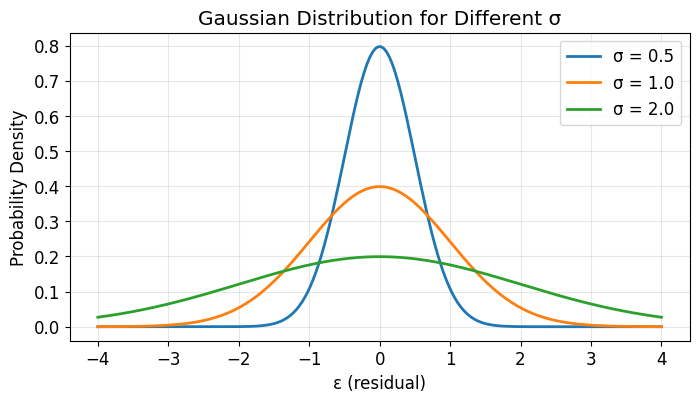

In [7]:
# Visualize Gaussian PDF
x = np.linspace(-4, 4, 200)

fig, ax = plt.subplots(figsize=(8, 4))
for sigma in [0.5, 1.0, 2.0]:
    pdf = stats.norm.pdf(x, 0, sigma)
    ax.plot(x, pdf, linewidth=2, label=f'σ = {sigma}')

ax.set_xlabel('ε (residual)')
ax.set_ylabel('Probability Density')
ax.set_title('Gaussian Distribution for Different σ')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

### Step 2: Write the Likelihood

For $n$ independent observations:

$$L(\theta) = \prod_{i=1}^{n} p(y_i | x_i, \theta) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y_i - f(x_i))^2}{2\sigma^2}\right)$$

### Step 3: Take the Log-Likelihood

$$\log L(\theta) = -\frac{n}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}(y_i - f(x_i))^2$$

### Step 4: Maximize Log-Likelihood = Minimize Negative Log-Likelihood

$$-\log L(\theta) = \frac{n}{2}\log(2\pi\sigma^2) + \frac{1}{2\sigma^2}\sum_{i=1}^{n}(y_i - f(x_i))^2$$

### Step 5: Drop Constants

The constants don't affect which $\theta$ minimizes the loss:

$$\arg\min_\theta \left[-\log L(\theta)\right] = \arg\min_\theta \sum_{i=1}^{n}(y_i - f(x_i))^2 = \arg\min_\theta [n \cdot \text{MSE}]$$

### Conclusion

$$\boxed{\text{Gaussian noise} \implies \text{MSE loss}}$$

**The MEAN is the MLE estimator for the center of a Gaussian!**

### Empirical Proof: Mean Minimizes MSE

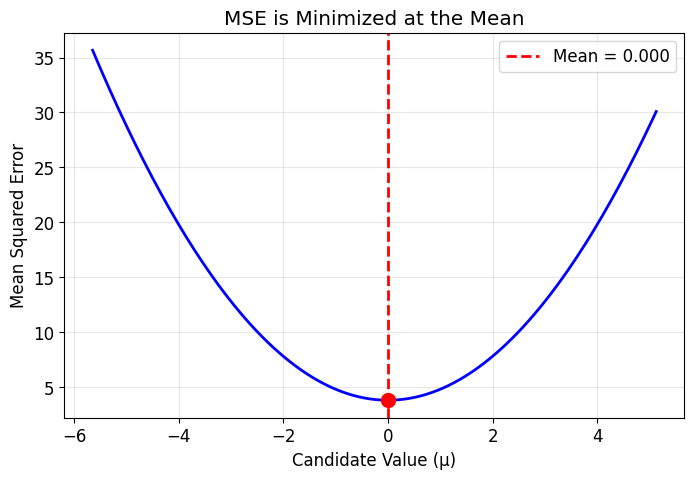

In [8]:
# Show that mean minimizes MSE
data = residuals
data_mean = np.mean(data)
candidates = np.linspace(data.min(), data.max(), 200)
mse_values = [np.mean((data - c)**2) for c in candidates]

plt.figure(figsize=(8, 5))
plt.plot(candidates, mse_values, 'b-', linewidth=2)
plt.axvline(data_mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {data_mean:.3f}')
plt.scatter([data_mean], [np.mean((data - data_mean)**2)], color='red', s=100, zorder=5)
plt.xlabel('Candidate Value (μ)')
plt.ylabel('Mean Squared Error')
plt.title('MSE is Minimized at the Mean')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---
## 1.3 From Laplace MLE to MAE

**What if we assume a different distribution?**

### The Laplace Distribution

Also called "double exponential" — it's the pointy cousin of Gaussian:

$$p(\epsilon) = \frac{1}{2b}\exp\left(-\frac{|\epsilon|}{b}\right)$$

Key property: **Heavier tails** than Gaussian!

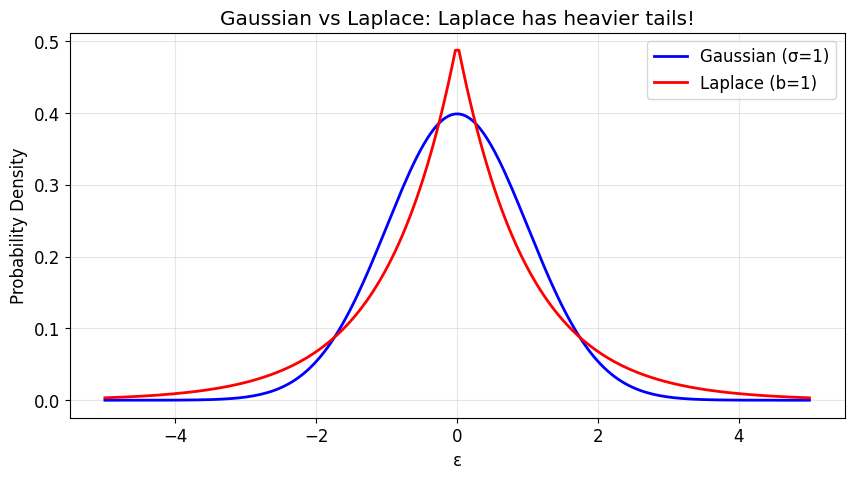

In [9]:
# Compare Gaussian vs Laplace
x = np.linspace(-5, 5, 200)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, stats.norm.pdf(x, 0, 1), 'b-', linewidth=2, label='Gaussian (σ=1)')
ax.plot(x, stats.laplace.pdf(x, 0, 1), 'r-', linewidth=2, label='Laplace (b=1)')
ax.set_xlabel('ε')
ax.set_ylabel('Probability Density')
ax.set_title('Gaussian vs Laplace: Laplace has heavier tails!')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

### Derivation: Laplace → MAE

**Step 1:** Laplace PDF: $p(\epsilon) = \frac{1}{2b}\exp\left(-\frac{|\epsilon|}{b}\right)$

**Step 2:** Log-likelihood:
$$\log L(\theta) = -n\log(2b) - \frac{1}{b}\sum_{i=1}^n |y_i - f(x_i)|$$

**Step 3:** Minimize negative log-likelihood (drop constants):
$$\arg\min_\theta \sum_{i=1}^n |y_i - f(x_i)| = \arg\min_\theta [n \cdot \text{MAE}]$$

### Conclusion

$$\boxed{\text{Laplace noise} \implies \text{MAE loss}}$$

**The MEDIAN is the MLE estimator for the center of a Laplace!**

### Empirical Proof: Median Minimizes MAE

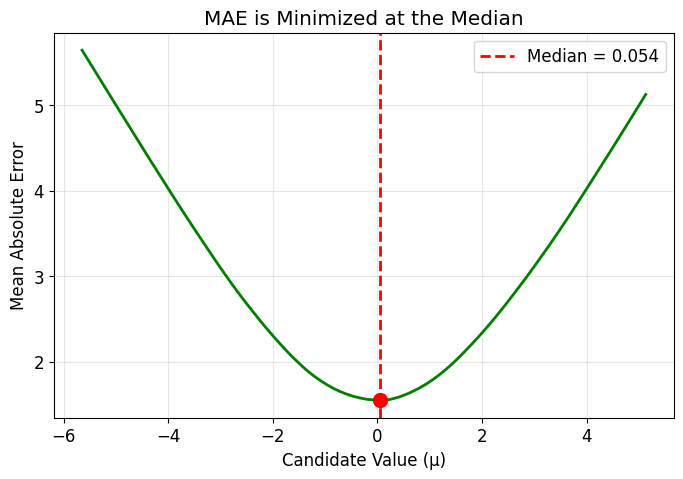

In [10]:
# Show that median minimizes MAE
data_median = np.median(data)
mae_values = [np.mean(np.abs(data - c)) for c in candidates]

plt.figure(figsize=(8, 5))
plt.plot(candidates, mae_values, 'g-', linewidth=2)
plt.axvline(data_median, color='red', linestyle='--', linewidth=2, label=f'Median = {data_median:.3f}')
plt.scatter([data_median], [np.mean(np.abs(data - data_median))], color='red', s=100, zorder=5)
plt.xlabel('Candidate Value (μ)')
plt.ylabel('Mean Absolute Error')
plt.title('MAE is Minimized at the Median')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---
## 1.4 The Universal Pattern

| Assumed Distribution | Loss Function | Optimal Estimator |
|---------------------|---------------|-------------------|
| Gaussian | MSE | Mean |
| Laplace | MAE | Median |
| Bernoulli | Cross-Entropy | (classification) |

---
## 1.5 MSE vs MAE with Outliers

**Why does this matter in practice?**

### Generate data with outliers

In [11]:
n_samples = 200
outlier_fraction = 0.1

X_clean = np.random.randn(n_samples, 1) * 2
y_clean = 2.0 * X_clean.flatten() + 1.0 + np.random.randn(n_samples) * 0.5

# Add outliers
n_outliers = int(n_samples * outlier_fraction)
outlier_idx = np.random.choice(n_samples, n_outliers, replace=False)
y_with_outliers = y_clean.copy()
y_with_outliers[outlier_idx] += np.random.choice([-1, 1], n_outliers) * 10  # Big outliers!

is_outlier = np.zeros(n_samples, dtype=bool)
is_outlier[outlier_idx] = True

print(f"Created {n_samples} samples with {n_outliers} outliers ({outlier_fraction*100:.0f}%)")

Created 200 samples with 20 outliers (10%)


### Visualize the data

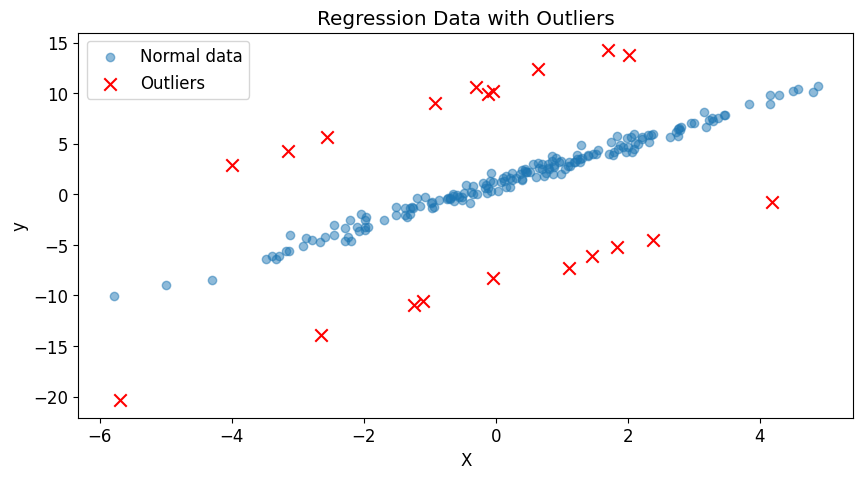

In [12]:
plt.figure(figsize=(10, 5))
plt.scatter(X_clean[~is_outlier], y_with_outliers[~is_outlier], alpha=0.5, label='Normal data')
plt.scatter(X_clean[is_outlier], y_with_outliers[is_outlier], color='red', s=80, label='Outliers', marker='x')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Regression Data with Outliers')
plt.legend()
plt.show()

### Loss Function Shapes

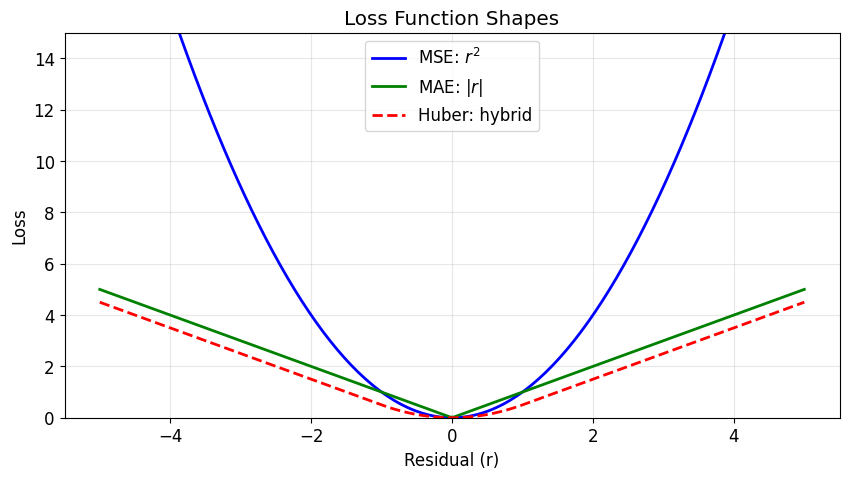

In [13]:
residual = np.linspace(-5, 5, 200)

mse_loss = residual ** 2
mae_loss = np.abs(residual)
huber_delta = 1.0
huber_loss = np.where(np.abs(residual) <= huber_delta,
                      0.5 * residual**2,
                      huber_delta * (np.abs(residual) - 0.5 * huber_delta))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(residual, mse_loss, 'b-', linewidth=2, label='MSE: $r^2$')
ax.plot(residual, mae_loss, 'g-', linewidth=2, label='MAE: $|r|$')
ax.plot(residual, huber_loss, 'r--', linewidth=2, label='Huber: hybrid')
ax.set_xlabel('Residual (r)')
ax.set_ylabel('Loss')
ax.set_title('Loss Function Shapes')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 15)
plt.show()

**Key observation:**
- MSE: Quadratic — outliers are penalized **heavily** ($5^2 = 25$)
- MAE: Linear — outliers penalized **proportionally** ($|5| = 5$)

### Compare model fits

In [14]:
from sklearn.linear_model import LinearRegression, HuberRegressor

# Fit with MSE (standard linear regression)
model_mse = LinearRegression()
model_mse.fit(X_clean, y_with_outliers)

# Fit with Huber (robust)
model_huber = HuberRegressor(epsilon=1.35)
model_huber.fit(X_clean, y_with_outliers)

print("True relationship: y = 2.0x + 1.0")
print(f"MSE model:   y = {model_mse.coef_[0]:.2f}x + {model_mse.intercept_:.2f}")
print(f"Huber model: y = {model_huber.coef_[0]:.2f}x + {model_huber.intercept_:.2f}")

True relationship: y = 2.0x + 1.0
MSE model:   y = 1.92x + 1.03
Huber model: y = 2.00x + 1.00


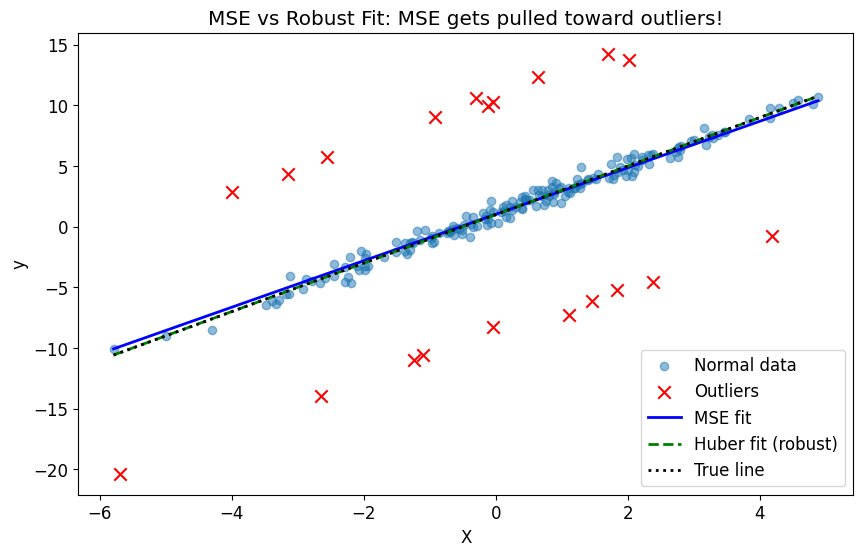

In [15]:
x_plot = np.linspace(X_clean.min(), X_clean.max(), 100).reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.scatter(X_clean[~is_outlier], y_with_outliers[~is_outlier], alpha=0.5, label='Normal data')
plt.scatter(X_clean[is_outlier], y_with_outliers[is_outlier], color='red', s=80, label='Outliers', marker='x')
plt.plot(x_plot, model_mse.predict(x_plot), 'b-', linewidth=2, label='MSE fit')
plt.plot(x_plot, model_huber.predict(x_plot), 'g--', linewidth=2, label='Huber fit (robust)')
plt.plot(x_plot, 2.0 * x_plot + 1.0, 'k:', linewidth=2, label='True line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('MSE vs Robust Fit: MSE gets pulled toward outliers!')
plt.legend()
plt.show()

### Key Insight

| Loss | Behavior with Outliers | When to Use |
|------|----------------------|-------------|
| MSE | Gets pulled toward outliers | All data points matter equally |
| MAE | Ignores outliers | Outliers are errors/noise |
| Huber | Compromise | Unsure about outliers |

---
## 1.6 Model Misspecification

**Warning: Loss functions can NOT fix wrong model architecture!**

In [16]:
# Generate quadratic data
X_quad = np.linspace(-3, 3, 200).reshape(-1, 1)
y_quad = X_quad.flatten()**2 + np.random.randn(200) * 0.5  # Quadratic!

# Fit LINEAR model (wrong!)
model_wrong = LinearRegression()
model_wrong.fit(X_quad, y_quad)
y_pred_wrong = model_wrong.predict(X_quad)

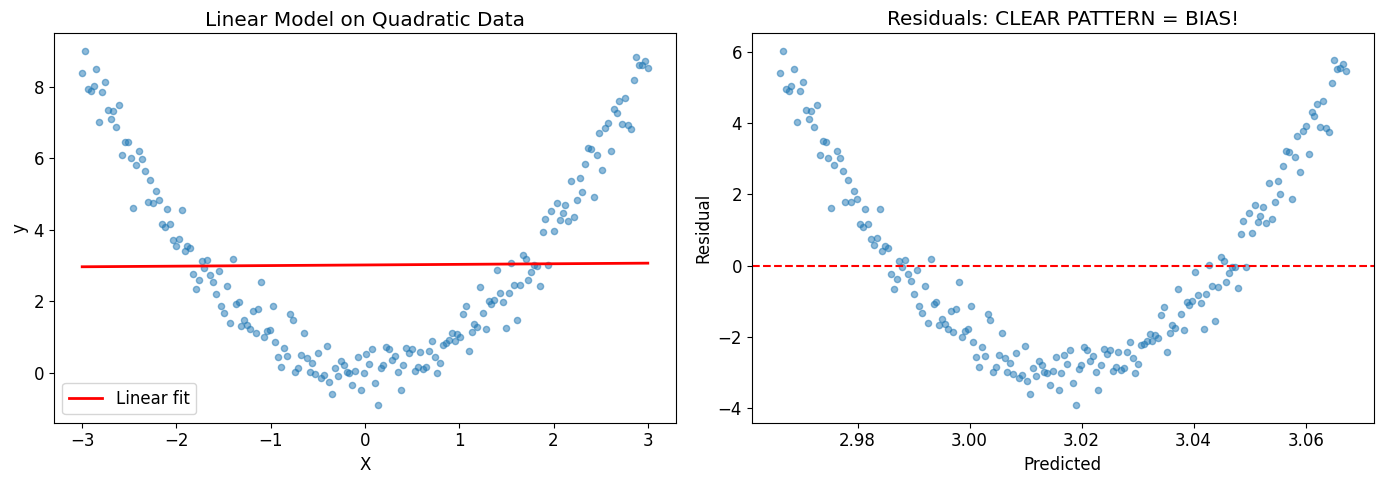

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Data and fit
axes[0].scatter(X_quad, y_quad, alpha=0.5, s=20)
axes[0].plot(X_quad, y_pred_wrong, 'r-', linewidth=2, label='Linear fit')
axes[0].set_xlabel('X')
axes[0].set_ylabel('y')
axes[0].set_title('Linear Model on Quadratic Data')
axes[0].legend()

# Right: Residuals
residuals_wrong = y_quad - y_pred_wrong
axes[1].scatter(y_pred_wrong, residuals_wrong, alpha=0.5, s=20)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residuals: CLEAR PATTERN = BIAS!')

plt.tight_layout()
plt.show()

### Key Insight

> **Patterns in residuals = Model BIAS = Wrong architecture!**
>
> No loss function can fix this. First get the architecture right, then choose loss.

---
# Part 1.5: Regularization & Bias-Variance
---

## 2.1 Regularization = Prior Belief (MAP)

**Key connection:** Regularization is NOT arbitrary — it's Bayesian!

| Framework | What we maximize |
|-----------|------------------|
| MLE | $P(\text{data} \mid \theta)$ |
| MAP | $P(\text{data} \mid \theta) \cdot P(\theta)$ |

The prior $P(\theta)$ becomes the regularization term!

### Ridge Regression: Gaussian Prior → L2 Penalty

**Prior:** Each coefficient is drawn from a Gaussian:
$$\theta_j \sim \mathcal{N}(0, \tau^2)$$

**MAP objective:**
$$\mathcal{L}_{\text{Ridge}} = \underbrace{\|y - X\theta\|^2}_{\text{MSE}} + \underbrace{\lambda\|\theta\|^2}_{\text{L2 penalty}}$$

where $\lambda = \sigma^2/\tau^2$

### Lasso Regression: Laplace Prior → L1 Penalty

**Prior:** Each coefficient is drawn from a Laplace:
$$\theta_j \sim \text{Laplace}(0, b)$$

**MAP objective:**
$$\mathcal{L}_{\text{Lasso}} = \underbrace{\|y - X\theta\|^2}_{\text{MSE}} + \underbrace{\lambda\|\theta\|_1}_{\text{L1 penalty}}$$

### Visualize the priors

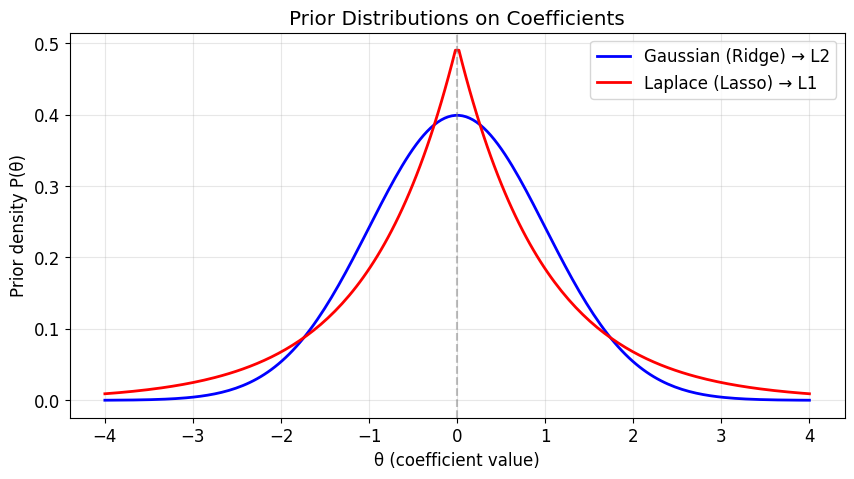

In [18]:
theta = np.linspace(-4, 4, 200)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(theta, stats.norm.pdf(theta, 0, 1), 'b-', linewidth=2, label='Gaussian (Ridge) → L2')
ax.plot(theta, stats.laplace.pdf(theta, 0, 1), 'r-', linewidth=2, label='Laplace (Lasso) → L1')
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('θ (coefficient value)')
ax.set_ylabel('Prior density P(θ)')
ax.set_title('Prior Distributions on Coefficients')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

**Key difference:**
- **Gaussian (Ridge):** Smooth peak → shrinks ALL coefficients toward 0
- **Laplace (Lasso):** Sharp peak → makes SOME coefficients EXACTLY 0 (sparsity!)

### Regularization Paths

In [19]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

# Generate data with some features
np.random.seed(42)
n, p = 100, 10
X_reg = np.random.randn(n, p)
true_coefs = np.array([3.0, -2.0, 1.5, 0, 0, 0, 0.5, 0, -0.3, 0])
y_reg = X_reg @ true_coefs + np.random.randn(n) * 0.5

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reg)

# Compute paths
alphas = np.logspace(-3, 3, 100)
ridge_coefs = []
lasso_coefs = []

for alpha in alphas:
    ridge_coefs.append(Ridge(alpha=alpha).fit(X_scaled, y_reg).coef_)
    lasso_coefs.append(Lasso(alpha=alpha, max_iter=10000).fit(X_scaled, y_reg).coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

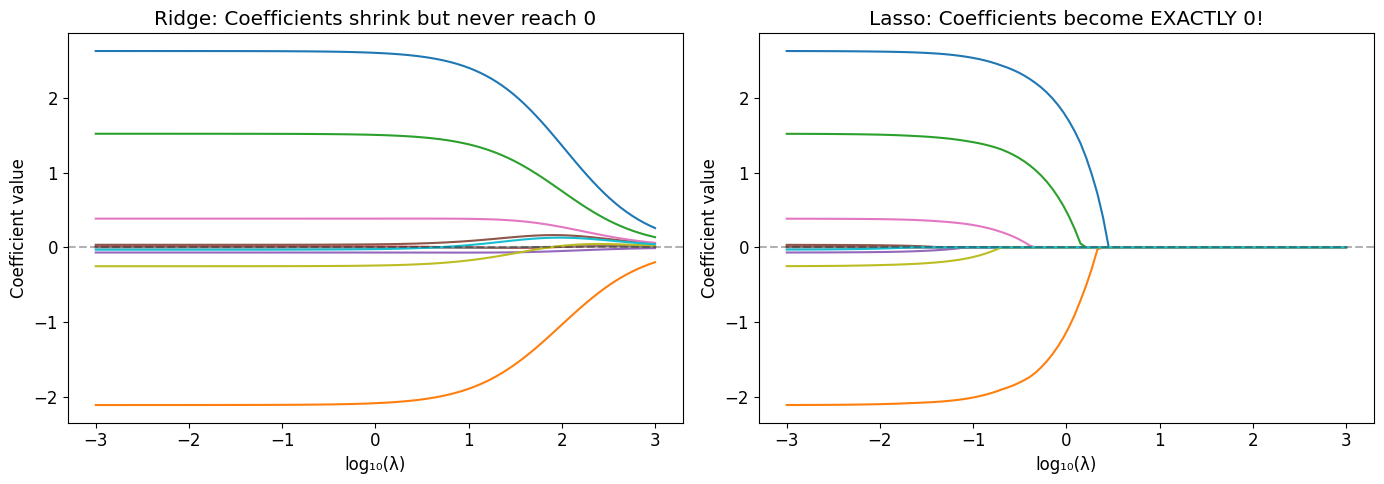

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ridge path
for i in range(p):
    axes[0].plot(np.log10(alphas), ridge_coefs[:, i], label=f'β_{i}')
axes[0].set_xlabel('log₁₀(λ)')
axes[0].set_ylabel('Coefficient value')
axes[0].set_title('Ridge: Coefficients shrink but never reach 0')
axes[0].axhline(0, color='black', linestyle='--', alpha=0.3)

# Lasso path
for i in range(p):
    axes[1].plot(np.log10(alphas), lasso_coefs[:, i], label=f'β_{i}')
axes[1].set_xlabel('log₁₀(λ)')
axes[1].set_ylabel('Coefficient value')
axes[1].set_title('Lasso: Coefficients become EXACTLY 0!')
axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 2.2 Bias-Variance Tradeoff

### The Fundamental Theorem

$$\mathbb{E}[(y - \hat{f}(x))^2] = \underbrace{\text{Bias}^2(\hat{f})}_{\text{systematic error}} + \underbrace{\text{Var}(\hat{f})}_{\text{sensitivity to training data}} + \underbrace{\sigma^2}_{\text{irreducible noise}}$$

### Definitions

- **Bias:** $\text{Bias}(\hat{f}) = \mathbb{E}[\hat{f}(x)] - f(x)$ — How far is the average prediction from truth?
- **Variance:** $\text{Var}(\hat{f}) = \mathbb{E}[(\hat{f}(x) - \mathbb{E}[\hat{f}(x)])^2]$ — How much does $\hat{f}$ change with different training data?

### The U-Curve

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# Generate nonlinear data
np.random.seed(42)
X_bv = np.linspace(-3, 3, 100).reshape(-1, 1)
y_true_bv = np.sin(X_bv.flatten()) + 0.5 * X_bv.flatten()
y_bv = y_true_bv + np.random.randn(100) * 0.5

# Train-test split
split = 70
X_train, X_test = X_bv[:split], X_bv[split:]
y_train, y_test = y_bv[:split], y_bv[split:]

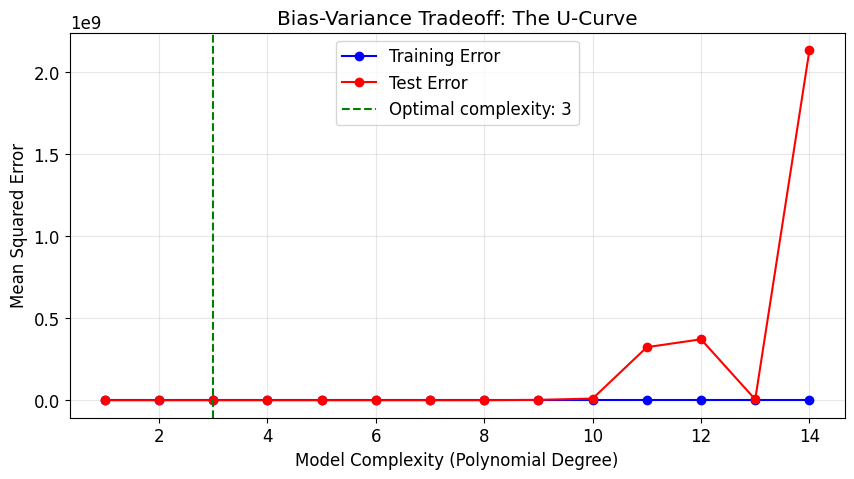

In [22]:
degrees = range(1, 15)
train_errors = []
test_errors = []

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), LinearRegression())
    model.fit(X_train, y_train)
    
    train_errors.append(np.mean((y_train - model.predict(X_train))**2))
    test_errors.append(np.mean((y_test - model.predict(X_test))**2))

plt.figure(figsize=(10, 5))
plt.plot(degrees, train_errors, 'b-o', label='Training Error')
plt.plot(degrees, test_errors, 'r-o', label='Test Error')
plt.axvline(degrees[np.argmin(test_errors)], color='green', linestyle='--', 
            label=f'Optimal complexity: {degrees[np.argmin(test_errors)]}')
plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('Mean Squared Error')
plt.title('Bias-Variance Tradeoff: The U-Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Key Insight

| Model Complexity | Bias | Variance | Total Error |
|-----------------|------|----------|-------------|
| Low (underfitting) | HIGH | Low | High |
| High (overfitting) | Low | HIGH | High |
| Optimal | Balanced | Balanced | **Minimum** |

### Regularization Trades Bias for Variance

$$\lambda \uparrow \implies \text{Bias} \uparrow \implies \text{Variance} \downarrow$$

---
# Part 2: Classification
---

## 3.1 The Bernoulli Distribution

For binary outcome $y \in \{0, 1\}$ with probability $p$:

$$P(y \mid p) = p^y (1-p)^{1-y}$$

This works because:
- If $y = 1$: $p^1 (1-p)^0 = p$ ✓
- If $y = 0$: $p^0 (1-p)^1 = 1-p$ ✓

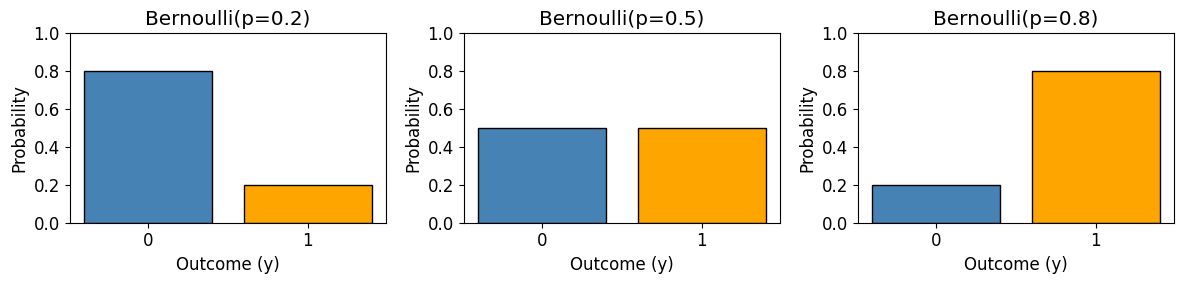

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for i, p in enumerate([0.2, 0.5, 0.8]):
    axes[i].bar([0, 1], [1-p, p], color=['steelblue', 'orange'], edgecolor='black')
    axes[i].set_title(f'Bernoulli(p={p})')
    axes[i].set_xlabel('Outcome (y)')
    axes[i].set_ylabel('Probability')
    axes[i].set_xticks([0, 1])
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

---
## 3.2 From Bernoulli MLE to Cross-Entropy

**Same pattern as regression!**

### Step 1: Write the Likelihood

$$L(\theta) = \prod_{i=1}^n p_i^{y_i} (1-p_i)^{1-y_i}$$

where $p_i = f(x_i; \theta)$ is the predicted probability

### Step 2: Take the Log-Likelihood

$$\log L(\theta) = \sum_{i=1}^n \left[ y_i \log(p_i) + (1-y_i)\log(1-p_i) \right]$$

### Step 3: Negative Log-Likelihood = Cross-Entropy!

$$\mathcal{L}_{\text{BCE}} = -\frac{1}{n}\sum_{i=1}^n \left[ y_i \log(p_i) + (1-y_i)\log(1-p_i) \right]$$

### Conclusion

$$\boxed{\text{Bernoulli assumption} \implies \text{Cross-Entropy loss}}$$

### Cross-Entropy Loss Shape

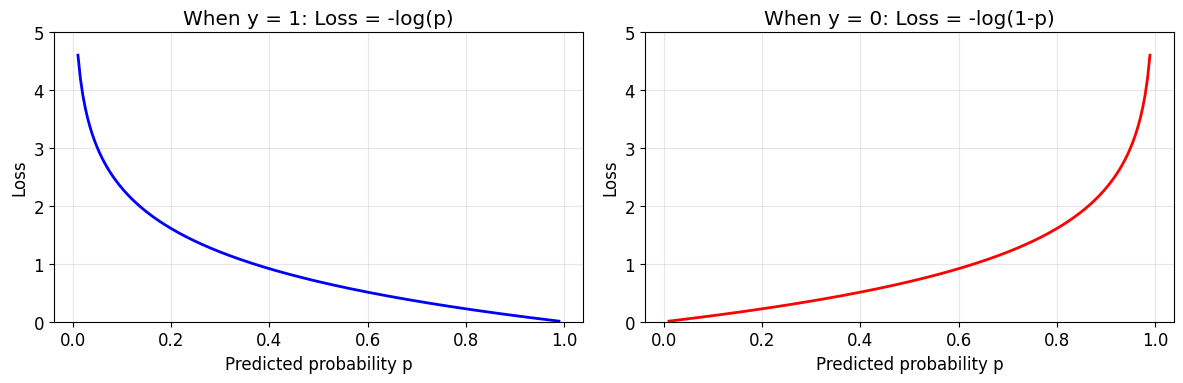

In [24]:
p = np.linspace(0.01, 0.99, 200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss when y = 1
axes[0].plot(p, -np.log(p), 'b-', linewidth=2)
axes[0].set_xlabel('Predicted probability p')
axes[0].set_ylabel('Loss')
axes[0].set_title('When y = 1: Loss = -log(p)')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 5)

# Loss when y = 0
axes[1].plot(p, -np.log(1-p), 'r-', linewidth=2)
axes[1].set_xlabel('Predicted probability p')
axes[1].set_ylabel('Loss')
axes[1].set_title('When y = 0: Loss = -log(1-p)')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 5)

plt.tight_layout()
plt.show()

**Key property:** Confident wrong predictions are penalized HEAVILY!

---
## 3.3 Class Imbalance: Why MLE Fails

**Problem:** With imbalanced data, majority class dominates the loss!

In [25]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Generate imbalanced data: 95% class 0, 5% class 1
np.random.seed(42)
n_samples = 1000
imbalance_ratio = 0.05

X_imb, y_imb = make_classification(
    n_samples=n_samples, n_features=10, n_informative=5,
    n_redundant=2, n_clusters_per_class=1,
    weights=[1 - imbalance_ratio, imbalance_ratio],
    random_state=42
)

print(f"Class distribution:")
print(f"  Class 0 (majority): {(y_imb == 0).sum()} ({(y_imb == 0).mean()*100:.1f}%)")
print(f"  Class 1 (minority): {(y_imb == 1).sum()} ({(y_imb == 1).mean()*100:.1f}%)")

Class distribution:
  Class 0 (majority): 946 (94.6%)
  Class 1 (minority): 54 (5.4%)


In [26]:
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imb, y_imb, test_size=0.2, random_state=42, stratify=y_imb
)

### Unweighted Model (Standard MLE)

In [27]:
model_unweighted = LogisticRegression(random_state=42, max_iter=1000)
model_unweighted.fit(X_train_imb, y_train_imb)
y_pred_unweighted = model_unweighted.predict(X_test_imb)

print("UNWEIGHTED MODEL (Standard MLE):")
print(f"  Accuracy:  {accuracy_score(y_test_imb, y_pred_unweighted):.3f}")
print(f"  Recall:    {recall_score(y_test_imb, y_pred_unweighted):.3f}")
print(f"  Precision: {precision_score(y_test_imb, y_pred_unweighted, zero_division=0):.3f}")
print(f"  F1:        {f1_score(y_test_imb, y_pred_unweighted):.3f}")

UNWEIGHTED MODEL (Standard MLE):
  Accuracy:  0.990
  Recall:    0.818
  Precision: 1.000
  F1:        0.900


### Weighted Model (Balanced MLE)

In [28]:
model_weighted = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model_weighted.fit(X_train_imb, y_train_imb)
y_pred_weighted = model_weighted.predict(X_test_imb)

print("WEIGHTED MODEL (Balanced MLE):")
print(f"  Accuracy:  {accuracy_score(y_test_imb, y_pred_weighted):.3f}")
print(f"  Recall:    {recall_score(y_test_imb, y_pred_weighted):.3f}")
print(f"  Precision: {precision_score(y_test_imb, y_pred_weighted, zero_division=0):.3f}")
print(f"  F1:        {f1_score(y_test_imb, y_pred_weighted):.3f}")

WEIGHTED MODEL (Balanced MLE):
  Accuracy:  0.975
  Recall:    0.909
  Precision: 0.714
  F1:        0.800


### Why This Happens

Cross-entropy loss:
$$\mathcal{L} = -\sum_i \left[ y_i \log(p_i) + (1-y_i)\log(1-p_i) \right]$$

With 950 negatives and 50 positives:
- 950 terms push toward predicting 0
- Only 50 terms push toward predicting 1

**Gradient is 19× more influenced by negatives!**

### Metric Sensitivity to Imbalance

| Metric | Sensitive to Imbalance? | Why? |
|--------|------------------------|------|
| Accuracy | YES ⚠️ | Dominated by TN from majority |
| Precision | Somewhat ⚠️ | FP comes from majority |
| **Recall** | **NO ✓** | Only looks at minority (TP + FN) |
| **AUC-ROC** | **NO ✓** | Normalized rates |
| **Avg Precision** | **NO ✓** | Focuses on positive class |

---
# Summary
---

## The Universal Pattern

1. Choose distributional assumption for $y \mid x$
2. Write likelihood function
3. Take negative log-likelihood
4. **That IS your loss function!**

| Problem | Distribution | Loss Function |
|---------|--------------|---------------|
| Regression | Gaussian | MSE |
| Regression | Laplace | MAE |
| Classification | Bernoulli | Cross-Entropy |

## Key Takeaways

1. **THREE distributions** in ML: Input, Function, **Residuals** (loss assumes about residuals!)
2. **MSE → Mean** because mean is MLE for Gaussian
3. **MAE → Median** because median is MLE for Laplace
4. **Regularization = Prior belief** (Ridge = Gaussian prior, Lasso = Laplace prior)
5. **Class imbalance** breaks MLE — weight your loss or use robust metrics!

> **Always check your residuals!**